# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

### Students

* Team: 37
* Students: Isabela Constantin, Adélie Garin, Celia Hacker, Michael Spieler
* Dataset: wikipedia

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [6]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [5]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [7]:
#we take the matrix of the biggest connected component (otherwise there are isolated points and the degree matrix is not invertible for normalized laplacian)
adjacency = np.load('largest_wcc.npz')['arr_0'] 
n_nodes =  adjacency.shape[0] # the number of nodes in the network
n_edges =  int(np.sum(adjacency)/2) # the number of edges in the network

#note: our graph contains selfloops. To compute the Laplacian and do the work below, we delete them.
adjacency = adjacency - np.diag(np.diag(adjacency))

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [13]:
degree_matrix = np.diag(np.sum(adjacency,axis=0))
laplacian_combinatorial =  degree_matrix - adjacency
laplacian_normalized = np.identity(n_nodes)-np.matmul(np.linalg.inv(scipy.linalg.sqrtm(degree_matrix)),np.matmul(adjacency, np.linalg.inv(scipy.linalg.sqrtm(degree_matrix))))                                                                        

Text(0.5,1.05,'Combinatorial Laplacian')

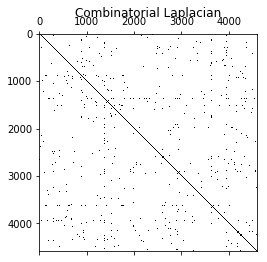

In [15]:
plt.spy(laplacian_combinatorial)
plt.title('Combinatorial Laplacian')

Text(0.5,1.05,'Normalized Laplacian')

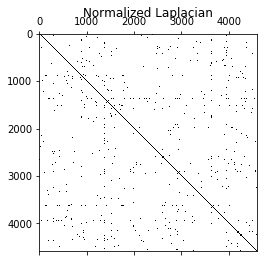

In [16]:
plt.spy(laplacian_normalized)
plt.title('Normalized Laplacian')

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [19]:
laplacian =  laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [21]:
#compute eigenvalues and eigenvectors, w= eigenvalues and v=eigenvectors
w,v= np.linalg.eig(laplacian)
#arrange eigenvalues in increasing order
idx= w.argsort()[::-1]

In [24]:
#re-arranged eigenvalues and eigenvectors
eigenvectors =  v[:,idx]
eigenvalues =  w[idx]

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

**Your answer here.** np.linalg.eig returns both eigenvalues and eigenvectors by solving the usual eigenproblem $Ax=\lambda x$. The eigenvectors of unit length (i think) 

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

S is the incidence matrix, it takes edges and return which vertices they link. $(S)_{ij}$ is +1 (resp -1) if the j-th edge has source (resp sink) the node i, $(S)_{ij}$ is 0 if the j-th edge is not incident to i. 

$S^\top$ takes nodes and return edges. The vector x is a signal on the nodes (it assigns a real value to each node) and $S^\top x$ is then a signal on the edges. It is the gradient of this node-signal x, i.e. the difference of the signal of the end-nodes of each edge. If the k-th edge has source i and sink j, $(S^\top x)_k = x_i-x_j$ (here we consider the unweighted case, otherwise there is a square root of the weight that comes up). 

Note: We need an orientation to define those properly, but in the case of undirected graph we can just define a random orientation. 

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

Finding eigenvalues of L is solving the equation $Lx = \lambda x $. Assume $ \|x \|=1$. Then is it equivalent to solving $x^\top Lx = x^\top \lambda x$ which is equivalent to solve $x^\top S S^\top x = x^\top \lambda x$ (as $L= S^\top S$). This gives the equation $\lambda=(x^\top S S^\top x) / (x^\top x )=\| S^\top x \|_2^2 / \| x \|_2 ^2  $. Hence solving $Lx = \lambda x $ for $ \|x \|=1$ is equivalent to solving $\| S^\top x \|_2^2 = \lambda$ for $\| x \|_2 ^2 =1 $, and for the eigenvalue $\lambda_k$ we have the associated eigenvector $u_k$ of norm 1 satisfying $\lambda_k = \| S^\top u_k \|_2^2$.

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

$\| S^\top x \|_2^2$ is the squared norm of the gradient of the signal x : $\| S^\top x \|_2^2 = x^\top S S^\top x = \sum_{i,j} (x_i-x_j)^2$ (unweighted case again). The smallest it is, the smoothest the signal x is (meaning the difference of signal at each edge is small). If $\| S^\top x \|_2^2 = 0$ then the signal x is constant, the smoothest possible. 

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your annswer here.**

For the combinatorial Laplacian L, minimizing $\| S^\top x \|_2^2$ corresponds to finding the first eigenvalue of L = $S^\top S$. As mentionned in Question 5, there is always the possibility of having a constant signal x and hence $\| S^\top x \|_2^2 = 0$ . The first eigenvalue is always 0, and its associated eigenvector of norm 1, $u_0$, is always constant. Its value is then $u_0 = (a ,..., a)$ where a is such that $a^2+...+a^2 = 1$ (norm of x is 1). 

The normalized Laplacian eigenvalues $ \{f_0,...f_k \} $ are linked to the ones of the combinatorial Laplacian $ \{u_0,...u_k\}$ by $u_i = D^{-1/2} f_i $, where D is the degree matrix. 


### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

In [ ]:
# Your code here.

**Your answer here.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [ ]:
# Your code here.

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

Combinatorial Laplacian: By Gershgorin circle theorem, any eigenvalue of a matrix is bounded by the largest absolute value sum of its row and columns. In our case, it gives twice maximal degree of the graph. This is unbounded, we can find a serie of graphs whose Laplacian eigenvalues go to infinity. 

Normalized Laplacian: One of the idea behind normalized Laplacian is to get bounded eigenvalues. The eigenvalues of the normalized Laplacian are all contained between 0 and 2. (the value 2 is attained if the graph has a complete bipartite component). 

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

The goal of Laplacian eigenmaps is to reduce dimension of the data while keeping important similarity properties. Points that are similar (meaning, close to each other) in the original graph will be close to each other in the embedding.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [ ]:
# Your code here.

Plot the nodes embedded in 2D. Comment on what you see.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

The embedding preserve smoothness of the signal. If we cluster the embedding, we obtain a good clustering of the original graph as well. 

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
# Your code here.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**

Each eigenvector minimize the gradient of the signal ($\sum (x_i-x_j)$) up to the condition to be orthogonal to the previous eigenvectors. Hence, the first eigenvectors each gives rise to a as-smooth-as-possible signal, where points that are close have close signal value and points that are far away have larger difference of values. It returns a good clustering. There are other methods to cluster a graph, for example one could use k-mean on nearest neigbors without using eigenvectors. The utility of projection on eigenvectors spaces in the reduction of dimension. 